In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

Learning Rate: 0.1
Epoch: 0 | Train Accuracy: 0.20 | Validation Accuracy: 0.20 | Test Accuracy: 0.19
Epoch: 1 | Train Accuracy: 0.12 | Validation Accuracy: 0.12 | Test Accuracy: 0.13
Epoch: 2 | Train Accuracy: 0.27 | Validation Accuracy: 0.26 | Test Accuracy: 0.26
Epoch: 3 | Train Accuracy: 0.30 | Validation Accuracy: 0.29 | Test Accuracy: 0.29
Epoch: 4 | Train Accuracy: 0.30 | Validation Accuracy: 0.29 | Test Accuracy: 0.28
Epoch: 5 | Train Accuracy: 0.18 | Validation Accuracy: 0.17 | Test Accuracy: 0.18
Epoch: 6 | Train Accuracy: 0.17 | Validation Accuracy: 0.17 | Test Accuracy: 0.17
Epoch: 7 | Train Accuracy: 0.16 | Validation Accuracy: 0.15 | Test Accuracy: 0.15
Epoch: 8 | Train Accuracy: 0.20 | Validation Accuracy: 0.19 | Test Accuracy: 0.20
Epoch: 9 | Train Accuracy: 0.19 | Validation Accuracy: 0.19 | Test Accuracy: 0.19
Epoch: 10 | Train Accuracy: 0.19 | Validation Accuracy: 0.18 | Test Accuracy: 0.18
Epoch: 11 | Train Accuracy: 0.10 | Validation Accuracy: 0.10 | Test Accuracy: 

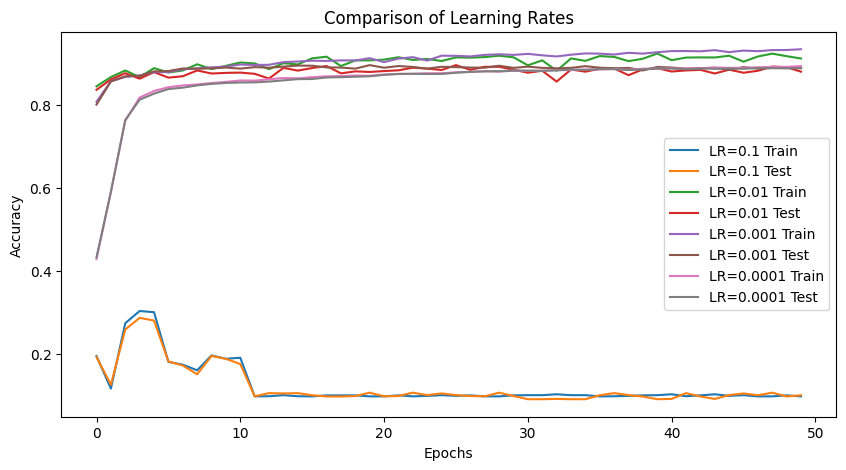

In [24]:
BATCH_SIZE = 32

# Function for loading notMNIST Dataset
def loadData(datafile = "notMNIST.npz"):
    with np.load(datafile) as data:
        Data, Target = data["images"].astype(np.float32), data["labels"]
        np.random.seed(7)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx] / 255.0
        Target = Target[randIndx]
        trainData, trainTarget = Data[:10000], Target[:10000]
        validData, validTarget = Data[10000:16000], Target[10000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

# Custom Dataset class.
class notMNIST(Dataset):
    def __init__(self, annotations, images, transform=None, target_transform=None):
        self.img_labels = annotations
        self.imgs = images
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.imgs[idx]
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

#Define FNN
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()

        #TODO
        #DEFINE YOUR LAYERS HERE

        # input array to 1st hidden layer
        self.d1 = nn.Linear(784, 10)
        # 1s hiddden layer to 2nd hidden layer
        self.d2 = nn.Linear(10, 10)
        # 2nd hiddden layer to output layer
        self.d3 = nn.Linear(10, 10)



    def forward(self, x):
        #TODO
        #DEFINE YOUR FORWARD FUNCTION HERE
        # flatten your input x of size (BATCH SIZE, 1, 28, 28) to the size of (BATCH SIZE, 784)
        x = torch.flatten(x, start_dim=1)
        # A fully connected layer followed by a ReLU activation: input -> 1st layer
        x = self.d1(x)
        x = F.relu(x)
        # A fully connected layer followed by a ReLU activation: 1st layer -> 2nd layer
        x = self.d2(x)
        x = F.relu(x)
        # A fully connected layer (without softmax activation): 2nd layer -> output layer
        out = self.d3(x)

        return out


# Commented out IPython magic to ensure Python compatibility.
# Compute accuracy
def get_accuracy(model, dataloader):

    model.eval()
    device = next(model.parameters()).device
    accuracy = 0.0
    total = 0.0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            # TODO
            # Return the accuracy
            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Update the running total of correct predictions and samples
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()  # Increment the correct count
    accuracy = accuracy / total


    return accuracy

def train(model, device, learning_rate, train_loader, val_loader, test_loader, num_epochs=50, verbose=False):
  #TODO
  # Define your cross entropy loss function here
  # Use cross entropy loss
  criterion = nn.CrossEntropyLoss()

  #TODO
  # Define your optimizer here
  # Use AdamW optimizer, set the weights, learning rate argument.
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


  acc_hist = {'train':[], 'val':[], 'test': []}

  for epoch in range(num_epochs):

    model = model.train()
    ## training step
    for i, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)

        # TODO
        # Follow the step in the tutorial
        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

    model.eval()
    acc_hist['train'].append(get_accuracy(model, train_loader))
    acc_hist['val'].append(get_accuracy(model, val_loader))
    acc_hist['test'].append(get_accuracy(model, test_loader))

    if verbose:
      print('Epoch: %d | Train Accuracy: %.2f | Validation Accuracy: %.2f | Test Accuracy: %.2f' \
           %(epoch, acc_hist['train'][-1], acc_hist['val'][-1], acc_hist['test'][-1]))

  return model, acc_hist

def experiment(learning_rate, num_epochs=50, verbose=False):
  # Use GPU if it is available.
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  # Inpute Batch size:
  BATCH_SIZE = 32

  # Convert images to tensor
  transform = transforms.Compose(
      [transforms.ToTensor()])

  # Get train, validation and test data loader.
  trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()

  train_data = notMNIST(trainTarget, trainData, transform=transform)
  val_data = notMNIST(validTarget, validData, transform=transform)
  test_data = notMNIST(testTarget, testData, transform=transform)


  train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

  # Specify which model to use
  model = FNN()

  # Loading model into device
  model = model.to(device)
  criterion = nn.CrossEntropyLoss()
  model, acc_hist = train(model, device, learning_rate, train_loader, val_loader, test_loader, num_epochs=num_epochs, verbose=verbose)

  # Release the model from the GPU (else the memory wont hold up)
  model.cpu()

  return model, acc_hist

def compare_lr(learning_rates, num_epochs=50):
    # Dictionary to hold accuracy for each learning rate
    accuracies = {}

    for lr in learning_rates:
        print(f"Learning Rate: {lr}")
        # Call the experiment function for each learning rate
        _, acc_hist = experiment(learning_rate=lr, num_epochs=num_epochs, verbose=True)
        accuracies[lr] = acc_hist

    # Plot the accuracies for each learning rate
    plt.figure(figsize=(10, 5))
    for lr, accuracy in accuracies.items():
        plt.plot(accuracy['train'], label=f"LR={lr} Train")
        plt.plot(accuracy['test'], label=f"LR={lr} Test")

    plt.title('Comparison of Learning Rates')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Learning Rates
learning_rates = [0.1, 0.01, 0.001, 0.0001]

compare_lr(learning_rates, num_epochs=50)
